# Experiment4
## Compare with traditional CDMs on different ratio: 10%, 20%, 30%, 40%, 50%

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
import Dina
from Dina import McmcHoDina
from Dina import MlDina
import pandas as pd
from utils import r4beta
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import progressbar
import collections
import random
from transformer import MyDataSet, Transformer

In [50]:
def load_data(path, ratio):
    full_data = pd.read_csv(path + 'data.txt', header=None, sep='\t').values
    q_matrix = pd.read_csv(path + 'q.txt', header=None, sep='\t').values
    num_samples, num_items, num_skills = full_data.shape[0], full_data.shape[1], q_matrix.shape[1]
    
    train_data = full_data[ : int(num_samples * ratio)]
    train_data = binary_classify(train_data)
    test_data = full_data[int(num_samples * ratio): ]
    test_data = binary_classify(test_data)
    
    return train_data, test_data, q_matrix, num_samples, num_items, num_skills

def binary_classify(data):
    data[data <= 0.5] = 0
    data[data > 0.5] = 1
    return data.astype(np.int64)

def get_scores(true_scores, pred_scores):

    fpr, tpr, thresholds = metrics.roc_curve(true_scores, pred_scores)
    pred_scores = binary_classify(pred_scores)
    loss_func = nn.MSELoss()
    rmse = np.sqrt(((true_scores - pred_scores) ** 2).mean())
    accuracy = accuracy_score(true_scores, pred_scores)
    precision = precision_score(true_scores, pred_scores)
    recall = recall_score(true_scores, pred_scores)
    f1 = f1_score(true_scores, pred_scores)
    roc_auc = roc_auc_score(true_scores, pred_scores)

    return rmse, accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc

def get_prior_skills(x, y, q_matrix):
    guess = r4beta(1, 2, 0, 0.6, (1, x.shape[1]))
    slip = r4beta(1, 2, 0, 0.6, (1, x.shape[1]))
    max_iter = 100
    tol = 1e-5
    EmDina = Dina.EmDina(guess, slip, max_iter, tol, q_matrix, x)
    est_s, est_g = EmDina.em()
    dina_est = Dina.MlDina(est_g, est_s, q_matrix, y)
    est_skills = dina_est.get_skills_by_Ml()
    return est_skills

def shuffle_data(x, y):
    num_sample = len(x)
    indices = list(range(num_sample))
    random.shuffle(indices)
    return x[indices], y[indices]

def sample_data(x, y, ratio):
    x, y = shuffle_data(x, y)
    x_sample = x[ : int(len(x) * ratio)]
    y_sample = x[ : int(len(x) * ratio)]
    return x_sample, y_sample

def create_dict():
    d = collections.OrderedDict()
    
    model1 = collections.OrderedDict()
    model1['accuracy_his'], model1['precision_his'], model1['recall_his'], model1['f1_his'], model1['roc_auc_his'], model1['fpr_his'], model1['tpr_his'] = [], [], [], [], [], [], []
    
    model2 = collections.OrderedDict()
    model2['accuracy_his'], model2['precision_his'], model2['recall_his'], model2['f1_his'], model2['roc_auc_his'], model2['fpr_his'], model2['tpr_his'] = [], [], [], [], [], [], []
    
    model3 = collections.OrderedDict()
    model3['accuracy_his'], model3['precision_his'], model3['recall_his'], model3['f1_his'], model3['roc_auc_his'], model3['fpr_his'], model3['tpr_his'] = [], [], [], [], [], [], []
    
    d['model1'] = model1
    d['model2'] = model2
    d['model3'] = model3
    return d

In [208]:
#x_train, y_train决定了谁来第一个
def train_dina_model(x_train, y_train, q_matrix, dataset):
    g = r4beta(1, 2, 0, 0.6, (1, x_train.shape[1]))
    s = r4beta(1, 2, 0, 0.6, (1, y_train.shape[1]))
    max_iter = 100
    tol = 1e-5
    print("> Training DINA......")
    EmDina = Dina.EmDina(g, s, max_iter, tol, q_matrix, x_train)
    est_s_dina, est_g_dina = EmDina.em()

    dina_state_dict = collections.OrderedDict()
    dina_state_dict['slip'] = est_s_dina
    dina_state_dict['guess'] = est_g_dina
    
    torch.save(dina_state_dict, './Results/models/DINA_state_dict_Experiment3_' + dataset + '.pt')
    return est_s_dina, est_g_dina

def test_dina_model(x_test, y_test, est_s_dina, est_g_dina, q_matrix, dataset):
    dina_est = Dina.MlDina(est_g_dina, est_s_dina, q_matrix, x_test)
    est_skills = dina_est.get_skills_by_Ml()
    eta = dina_est.get_eta(est_skills)
    predict = dina_est.get_P_success(eta, est_s_dina, est_g_dina)
    pred = predict.reshape(-1)
    true = y_test.reshape(-1)
    true = binary_classify(true)
    rmse, accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
    return rmse, accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc
    
def train_hodina_model(x_train, y_train, q_matrix, dataset):
    HoDina = McmcHoDina(Q=q_matrix, X=x_train, max_iter=5000, burn=3000)
    print("> Training Ho-DINA......")
    est_lam0, est_lam1, est_theta, est_skills, est_s_ho_dina, est_g_ho_dina = HoDina.mcmc()
    ho_dina_state_dict = collections.OrderedDict()
    ho_dina_state_dict['slip'] = est_s_ho_dina
    ho_dina_state_dict['guess'] = est_g_ho_dina
    torch.save(ho_dina_state_dict, './Results/models/HoDINA_state_dict_Experiment3_' + dataset + '.pt')
    return est_s_ho_dina, est_g_ho_dina
    
def test_hodina_model(x_test, y_test, est_s_ho_dina, est_g_ho_dina, q_matrix, dataset):
    dina_est = Dina.MlDina(est_g_ho_dina, est_s_ho_dina, q_matrix, x_test)
    est_skills = dina_est.get_skills_by_Ml()
    eta = dina_est.get_eta(est_skills)
    predict = dina_est.get_P_success(eta, est_s_ho_dina, est_g_ho_dina)
    pred = predict.reshape(-1)
    true = y_test.reshape(-1)
    true = binary_classify(true)
    rmse, accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
    return rmse, accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc

def train_transformer_model(x_train, y_train, x_test, y_test, q_matrix, num_samples, num_items, num_skills, epoch_size, batch_size, dataset):


    est_skills_train = get_prior_skills(x_train, y_train, q_matrix)
    enc_inputs_train = torch.LongTensor(x_train)
    dec_inputs_train = torch.LongTensor(est_skills_train)
    dec_outputs_train = torch.FloatTensor(y_train)
    
    est_skills_test = get_prior_skills(x_test, y_test, q_matrix)
    enc_inputs_test = torch.LongTensor(x_test)
    dec_inputs_test = torch.LongTensor(est_skills_test)
    dec_outputs_test = torch.FloatTensor(y_test)
    
    loader = Data.DataLoader(MyDataSet(enc_inputs_train, dec_inputs_train, dec_outputs_train), batch_size, True)
    transformer = Transformer(num_items, num_skills, d_model=32, d_ff=16, d_k=8, d_v=8, n_layers=3, n_heads=8, batch_size=batch_size)
    loss_func = nn.MSELoss()
    #optimizer = optim.SGD(model.parameters(), lr=1e-3)
    optimizer =optim.Adam(transformer.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    print("> Training Transformer......")
    max_auc = 0
    transformer_dict = transformer.state_dict()
    for epoch in range(epoch_size):
        
    
        for enc_inputs_batch, dec_inputs_batch, dec_outputs_batch in loader:

            outputs_batch, enc_self_attns, dec_self_attns, dec_enc_attns = transformer(enc_inputs_batch, dec_inputs_batch)

            loss = loss_func(outputs_batch, dec_outputs_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if loss < 0.01:
            torch.save(transformer.state_dict(), './Results/models/Transformer_state_dict_Experiment3_' + dataset + '.pt')
            break
        
        with torch.no_grad():
            outputs, enc_self_attns, dec_self_attns, dec_enc_attns = transformer(enc_inputs_test, dec_inputs_test)
            predict = outputs.detach().numpy()
            pred = predict.reshape(-1)
            true = y_test.reshape(-1)
            true = binary_classify(true)
            
        rmse, accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
        if roc_auc > max_auc:
            max_auc = roc_auc
            transformer_dict = transformer.state_dict()
            torch.save(transformer.state_dict(), './Results/models/Transformer_state_dict_Experiment3_' + dataset + '.pt')
    
    return transformer_dict
    
    
def test_transformer_model(x_test, y_test, q_matrix, transformer_dict, num_samples, num_items, num_skills, batch_size, dataset):
    with torch.no_grad():
        est_skills_test = get_prior_skills(x_test, y_test, q_matrix)
        enc_inputs_test = torch.LongTensor(x_test)
        dec_inputs_test = torch.LongTensor(est_skills_test)
        dec_outputs_test = torch.FloatTensor(y_test)
        transformer = Transformer(num_items, num_skills, d_model=32, d_ff=16, d_k=8, d_v=8, n_layers=3, n_heads=8, batch_size=batch_size)
        #transformer.load_state_dict(torch.load('./Results/models/Transformer_state_dict_Experiment3_' + dataset + '.pt'))
        transformer.load_state_dict(transformer_dict)
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = transformer(enc_inputs_test, dec_inputs_test)
        predict = outputs.detach().numpy()
        pred = predict.reshape(-1)
        true = y_test.reshape(-1)
        true = binary_classify(true)
        rmse, accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
        return rmse, accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc

In [209]:
def train_models(dataset, ratio, epoch_size):
    
    train_data, test_data, q_matrix, num_samples, num_items, num_skills = load_data('./'+ dataset + '/', ratio)
    x_train, y_train = train_data, train_data
    x_test, y_test = test_data, test_data
    results = create_dict()
    epoch_size = epoch_size
    batch_size = int(num_samples / 50)
    
    # DINA, train and valid 
    est_s_dina, est_g_dina = train_dina_model(x_train, y_train, q_matrix, dataset)
    rmse, accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = test_dina_model(x_test, y_test, est_s_dina, est_g_dina, q_matrix, dataset)
    print("DINA model    | RMSE: {:4.6f} | Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(rmse, accuracy, precision, recall, f1, roc_auc))
    
    # Ho-DINA, train and valid 
    est_s_ho_dina, est_g_ho_dina = train_hodina_model(x_train, y_train, q_matrix, dataset)
    rmse, accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = test_hodina_model(x_test, y_test, est_s_ho_dina, est_g_ho_dina, q_matrix, dataset)
    print("Ho-DINA model | RMSE: {:4.6f} | Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(rmse, accuracy, precision, recall, f1, roc_auc))
    
    # Transformer, train and valid 
    transformer_dict = train_transformer_model(x_train, y_train, x_test, y_test, q_matrix, num_samples, num_items, num_skills, epoch_size, batch_size, dataset)
    rmse, accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = test_transformer_model(x_test, y_test, q_matrix, transformer_dict, num_samples, num_items, num_skills, batch_size, dataset)
    print("Transformer   | RMSE: {:4.6f} | Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(rmse, accuracy, precision, recall, f1, roc_auc))

In [210]:
def train(dataset):
    test_ratio = np.arange(0.1, 0.6, 0.1)
    for ratio in test_ratio:
        train_ratio = 1 - ratio
        print(54 * "=" + "train ratio: {:}% ".format(int(train_ratio * 100)) + 54 * "=")
        train_models(dataset, train_ratio, 50)

In [211]:
train('FrcSub')
train('Math1')
train('Math2')

======================================================train ratio: 90% ======================================================
> Training DINA......
DINA model    | RMSE: 0.319142 | Accuracy: 0.898148 | Precision: 0.839879 | Recall: 0.829851 | F1: 0.834835 | AUC: 0.879355
> Training Ho-DINA......
Ho-DINA model | RMSE: 0.295020 | Accuracy: 0.912963 | Precision: 0.887460 | Recall: 0.823881 | F1: 0.854489 | AUC: 0.888450
> Training Transformer......
Transformer   | RMSE: 0.334719 | Accuracy: 0.887963 | Precision: 0.763547 | Recall: 0.925373 | F1: 0.836707 | AUC: 0.898257
======================================================train ratio: 80% ======================================================
> Training DINA......
DINA model    | RMSE: 0.329140 | Accuracy: 0.891667 | Precision: 0.875000 | Recall: 0.887526 | F1: 0.881218 | AUC: 0.891309
> Training Ho-DINA......
Ho-DINA model | RMSE: 0.319142 | Accuracy: 0.898148 | Precision: 0.893154 | Recall: 0.880368 | F1: 0.886715 | AUC: 0.896614
> Tra

In [45]:
def train_models(dataset, ratio, epoch_size):
    
    train_data, test_data, q_matrix, num_samples, num_items, num_skills = load_data('./'+ dataset + '/', ratio)
    x_train, y_train = train_data, train_data
    x_test, y_test = test_data, test_data
    results = create_dict()
    
    # model1
    
    guess = r4beta(1, 2, 0, 0.6, (1, x_train.shape[1]))
    slip = r4beta(1, 2, 0, 0.6, (1, y_train.shape[1]))
    max_iter = 100
    tol = 1e-5
    print("> Training DINA......")
    EmDina = Dina.EmDina(guess, slip, max_iter, tol, q_matrix, x_train)
    est_s_dina, est_g_dina = EmDina.em()

    dina_state_dict = collections.OrderedDict()
    dina_state_dict['slip'] = est_s_dina
    dina_state_dict['guess'] = est_g_dina
    
    torch.save(dina_state_dict, './Results/DINA_state_dict_Experiment3_' + dataset + '.pt')
    
    dina_est = Dina.MlDina(est_g_dina, est_s_dina, q_matrix, x_test)
    est_skills = dina_est.get_skills_by_Ml()
    eta = dina_est.get_eta(est_skills)
    predict = dina_est.get_P_success(eta, est_s_dina, est_g_dina)

    #predict = binary_classify(predict)
    pred = predict.reshape(-1)
    true = y_test.reshape(-1)
    true = binary_classify(true)
    accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
    #print("==================================================Test{}==================================================".format(i+1))
    #print("========================================================================================================")
    print("DINA model  | Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))
    results['model1']['accuracy_his'].append(accuracy)
    results['model1']['precision_his'].append(precision)
    results['model1']['recall_his'].append(recall)
    results['model1']['f1_his'].append(f1)
    results['model1']['roc_auc_his'].append(roc_auc)
    results['model1']['fpr_his'].append(fpr)
    results['model1']['tpr_his'].append(tpr)
    #torch.save(results, './Results/data/scores_Experiment3_' + dataset + '.pt')
    

    #model2
    HoDina = McmcHoDina(Q=q_matrix, X=x_train, max_iter=8000, burn=5000)
    
    print("> Training Ho-DINA......")
    est_lam0, est_lam1, est_theta, est_skills, est_s_ho_dina, est_g_ho_dina = HoDina.mcmc()
    ho_dina_state_dict = collections.OrderedDict()
    ho_dina_state_dict['slip'] = est_s_ho_dina
    ho_dina_state_dict['guess'] = est_g_ho_dina
    
    torch.save(ho_dina_state_dict, './Results/HoDINA_state_dict_Experiment3_' + dataset + '.pt')
    
    dina_est = Dina.MlDina(est_g_ho_dina, est_s_ho_dina, q_matrix, x_test)
    est_skills = dina_est.get_skills_by_Ml()
    eta = dina_est.get_eta(est_skills)
    predict = dina_est.get_P_success(eta, est_s_ho_dina, est_g_ho_dina)
    pred = predict.reshape(-1)
    true = y_test.reshape(-1)
    true = binary_classify(true)
    accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
    print("HoDINA model| Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))    
    results['model2']['accuracy_his'].append(accuracy)
    results['model2']['precision_his'].append(precision)
    results['model2']['recall_his'].append(recall)
    results['model2']['f1_his'].append(f1)
    results['model2']['roc_auc_his'].append(roc_auc)
    results['model2']['fpr_his'].append(fpr)
    results['model2']['tpr_his'].append(tpr)   
    #torch.save(results, './Results/data/scores_Experiment3_' + dataset + '.pt')
    
    # model3
    
    batch_size = int(num_samples / 50)
    src_len = num_items 
    tgt_len = num_items 

    est_skills_train = get_prior_skills(x_train, y_train, q_matrix)
    enc_inputs_train = torch.LongTensor(x_train)
    dec_inputs_train = torch.LongTensor(est_skills_train)
    dec_outputs_train = torch.FloatTensor(y_train)
    
    est_skills_test = get_prior_skills(x_test, y_test, q_matrix)
    enc_inputs_test = torch.LongTensor(x_test)
    dec_inputs_test = torch.LongTensor(est_skills_test)
    dec_outputs_test = torch.FloatTensor(y_test)
    
    loader = Data.DataLoader(MyDataSet(enc_inputs_train, dec_inputs_train, dec_outputs_train), batch_size, True)
    transformer = Transformer(num_items, num_skills, d_model=32, d_ff=16, d_k=8, d_v=8, n_layers=3, n_heads=8, batch_size=batch_size)
    loss_func = nn.MSELoss()
    #optimizer = optim.SGD(model.parameters(), lr=1e-3)
    optimizer =optim.Adam(transformer.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    print("> Training Transformer......")
    max_auc = 0
    for epoch in range(epoch_size):

        for enc_inputs_batch, dec_inputs_batch, dec_outputs_batch in loader:

            outputs_batch, enc_self_attns, dec_self_attns, dec_enc_attns = transformer(enc_inputs_batch, dec_inputs_batch)

            loss = loss_func(outputs_batch, dec_outputs_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if loss < 0.03:
            torch.save(transformer.state_dict(), './Results/Transformer_state_dict_Experiment3_' + dataset + '.pt')
            break
        
        with torch.no_grad():
            outputs, enc_self_attns, dec_self_attns, dec_enc_attns = transformer(enc_inputs_test, dec_inputs_test)
            predict = outputs.detach().numpy()
            pred = predict.reshape(-1)
            true = y_test.reshape(-1)
            true = binary_classify(true)
            
        accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
        
        if roc_auc > max_auc:
            max_auc = roc_auc
            torch.save(transformer.state_dict(), './Results/Transformer_state_dict_Experiment3_' + dataset + '.pt')
                # test mdoel3
    with torch.no_grad():
        transformer = Transformer(num_items, num_skills, d_model=32, d_ff=16, d_k=8, d_v=8, n_layers=3, n_heads=8, batch_size=batch_size)
        transformer.load_state_dict(torch.load('./Results/Transformer_state_dict_Experiment3_' + dataset + '.pt'))
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = transformer(enc_inputs_test, dec_inputs_test)
        predict = outputs.detach().numpy()
        pred = predict.reshape(-1)
        true = y_test.reshape(-1)
        true = binary_classify(true)
        accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
        print("Transformer | Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))        
    
    results['model3']['accuracy_his'].append(accuracy)
    results['model3']['precision_his'].append(precision)
    results['model3']['recall_his'].append(recall)
    results['model3']['f1_his'].append(f1)
    results['model3']['roc_auc_his'].append(roc_auc)
    results['model3']['fpr_his'].append(fpr)
    results['model3']['tpr_his'].append(tpr)   
    
    torch.save(results, './Results/data/scores_Experiment3_' + dataset + '.pt')

In [5]:
train_models('FrcSub', 0.8, 50)

> Training DINA......
DINA model  | Accuracy: 0.891667 | Precision: 0.875000 | Recall: 0.887526 | F1: 0.881218 | AUC: 0.891309
> Training Ho-DINA......
HoDINA model| Accuracy: 0.898611 | Precision: 0.898216 | Recall: 0.875256 | F1: 0.886587 | AUC: 0.896596
> Training Transformer......
Transformer | Accuracy: 0.900000 | Precision: 0.867761 | Recall: 0.919223 | F1: 0.892751 | AUC: 0.901659


In [6]:
train_models('Math1', 0.8, 50)

> Training DINA......
DINA model  | Accuracy: 0.781116 | Precision: 0.708429 | Recall: 0.881885 | F1: 0.785698 | AUC: 0.789439
> Training Ho-DINA......
HoDINA model| Accuracy: 0.783907 | Precision: 0.740985 | Recall: 0.807230 | F1: 0.772690 | AUC: 0.785834
> Training Transformer......
Transformer | Accuracy: 0.812114 | Precision: 0.772408 | Recall: 0.832289 | F1: 0.801231 | AUC: 0.813780


In [7]:
train_models('Math2', 0.8, 50)

> Training DINA......
DINA model  | Accuracy: 0.789655 | Precision: 0.733433 | Recall: 0.801487 | F1: 0.765951 | AUC: 0.791118
> Training Ho-DINA......
HoDINA model| Accuracy: 0.807407 | Precision: 0.784738 | Recall: 0.760000 | F1: 0.772171 | AUC: 0.801544
> Training Transformer......
Transformer | Accuracy: 0.846041 | Precision: 0.842490 | Recall: 0.788996 | F1: 0.814866 | AUC: 0.838986


# Test draw

In [2]:
results_FrcSub = torch.load('./Results/data/scores_Experiment3_' + 'FrcSub' + '.pt')
results_Math1 = torch.load('./Results/data/scores_Experiment3_' + 'Math1' + '.pt')
results_Math2 = torch.load('./Results/data/scores_Experiment3_' + 'Math1' + '.pt')

fpr_list_FrcSub, tpr_list_FrcSub, fpr_list_Math1, tpr_list_Math1, fpr_list_Math2,  tpr_list_Math2 = [], [], [], [], [], []

fpr_list_FrcSub = [results_FrcSub['model1']['fpr_his'], results_FrcSub['model2']['fpr_his'], results_FrcSub['model3']['fpr_his']]
tpr_list_FrcSub = [results_FrcSub['model1']['tpr_his'], results_FrcSub['model2']['tpr_his'], results_FrcSub['model3']['tpr_his']]
auc_list_FrcSub = [results_FrcSub['model1']['roc_auc_his'], results_FrcSub['model2']['roc_auc_his'], results_FrcSub['model3']['roc_auc_his']]

fpr_list_Math1 = [results_Math1['model1']['fpr_his'], results_Math1['model2']['fpr_his'], results_Math1['model3']['fpr_his']]
tpr_list_Math1 = [results_Math1['model1']['tpr_his'], results_Math1['model2']['tpr_his'], results_Math1['model3']['tpr_his']]
auc_list_Math1 = [results_Math1['model1']['roc_auc_his'], results_Math1['model2']['roc_auc_his'], results_Math1['model3']['roc_auc_his']]

fpr_list_Math2 = [results_Math2['model1']['fpr_his'], results_Math2['model2']['fpr_his'], results_Math2['model3']['fpr_his']]
tpr_list_Math2 = [results_Math2['model1']['tpr_his'], results_Math2['model2']['tpr_his'], results_Math2['model3']['tpr_his']]
auc_list_Math2 = [results_Math2['model1']['roc_auc_his'], results_Math2['model2']['roc_auc_his'], results_Math2['model3']['roc_auc_his']]

In [3]:
def draw_roc_curve(results, dataset):
    plt.grid(b=True, color='gray', linestyle='--', linewidth=1, alpha=0.8)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(results['model1']['fpr_his'][0], results['model1']['tpr_his'][0], linestyle=':', color='purple', lw=2, label='FrcSub (area = %0.3f)' % results['model1']['roc_auc_his'][0])
    plt.plot(results['model2']['fpr_his'][0], results['model2']['tpr_his'][0], linestyle='-.', color='orange', lw=2, label='Math1  (area = %0.3f)' % results['model2']['roc_auc_his'][0])
    plt.plot(results['model3']['fpr_his'][0], results['model3']['tpr_his'][0], linestyle='-', color='red', lw=2, label='Math2  (area = %0.3f)' % results['model3']['roc_auc_his'][0])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic on ' + dataset)
    plt.legend(loc="lower right")
    plt.savefig('./Results/roc_' + dataset + '_Experiment3.png', dpi=750, bbox_inches = 'tight')

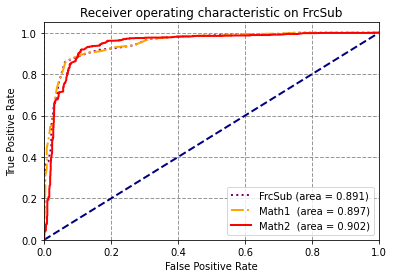

In [11]:
draw_roc_curve(results_FrcSub, 'FrcSub')

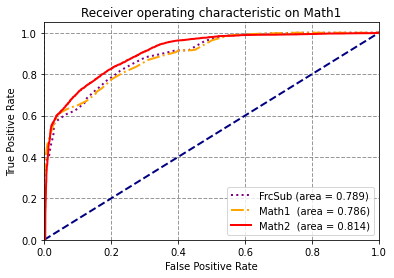

In [12]:
draw_roc_curve(results_Math1, 'Math1')

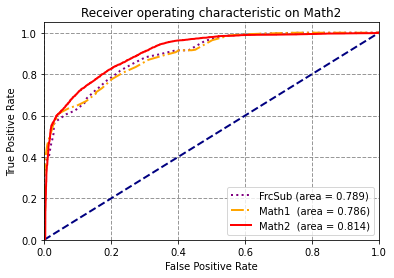

In [13]:
draw_roc_curve(results_Math2, 'Math2')

In [10]:
def evaluation(dataset='FrcSub', test_times=10, ratio=0.8):
    #ratio=0全部用于随机抽取
    train_data, test_data, q_matrix, num_samples, num_items, num_skills = load_data('./'+ dataset + '/', 0.) 
    results = create_dict()
    
    #load model1
    dina_state_dict = torch.load('./Results/DINA_state_dict_Experiment3_' + dataset + '.pt')
    est_s_dina = dina_state_dict['slip']
    est_g_dina = dina_state_dict['guess']
    
    
    #load model2
    ho_dina_state_dict = torch.load('./Results/HoDINA_state_dict_Experiment3_' + dataset + '.pt')
    est_s_ho_dina = ho_dina_state_dict['slip']
    est_g_ho_dina = ho_dina_state_dict['guess']
    
    
    #load model3
    batch_size = int(num_samples / 50)
    src_len = num_items 
    tgt_len = num_items 
    transformer = Transformer(num_items, num_skills, d_model=512, d_ff=64, d_k=16, d_v=16, n_layers=3, n_heads=8, batch_size=batch_size)
    transformer.load_state_dict(torch.load('./Results/Transformer_state_dict_Experiment3_' + dataset + '.pt'))

    
    for i in range(test_times):
        x_test, y_test = sample_data(test_data, test_data, ratio)
        
        # test mdoel1
        dina_est = Dina.MlDina(est_g_dina, est_s_dina, q_matrix, x_test)
        est_skills = dina_est.get_skills_by_Ml()
        eta = dina_est.get_eta(est_skills)
        predict = dina_est.get_P_success(eta, est_s_dina, est_g_dina)
        
        #predict = binary_classify(predict)
        pred = predict.reshape(-1)
        true = y_test.reshape(-1)
        true = binary_classify(true)
        accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
        #print(len(fpr))
        #break
        #print("==================================================Test{}==================================================".format(i+1))
        print("========================================================================================================")
        print("DINA model  | Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))
        results['model1']['accuracy_his'].append(accuracy)
        results['model1']['precision_his'].append(precision)
        results['model1']['recall_his'].append(recall)
        results['model1']['f1_his'].append(f1)
        results['model1']['roc_auc_his'].append(roc_auc)
        results['model1']['fpr_his'].append(fpr)
        results['model1']['tpr_his'].append(tpr)
        
        # test mdoel2
        dina_est = Dina.MlDina(est_g_ho_dina, est_s_ho_dina, q_matrix, x_test)
        est_skills = dina_est.get_skills_by_Ml()
        eta = dina_est.get_eta(est_skills)
        predict = dina_est.get_P_success(eta, est_s_ho_dina, est_g_ho_dina)
        pred = predict.reshape(-1)
        true = y_test.reshape(-1)
        true = binary_classify(true)
        accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(pred, true)
        print("HoDINA model| Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))    
        results['model2']['accuracy_his'].append(accuracy)
        results['model2']['precision_his'].append(precision)
        results['model2']['recall_his'].append(recall)
        results['model2']['f1_his'].append(f1)
        results['model2']['roc_auc_his'].append(roc_auc)
        results['model2']['fpr_his'].append(fpr)
        results['model2']['tpr_his'].append(tpr)        
        
        # test mdoel3
        with torch.no_grad():
            est_skills = get_prior_skills(x_test, y_test, q_matrix)
            enc_inputs = torch.LongTensor(x_test)
            dec_inputs = torch.LongTensor(est_skills)
            dec_outputs = torch.FloatTensor(y_test)
            outputs, enc_self_attns, dec_self_attns, dec_enc_attns = transformer(enc_inputs, dec_inputs)
            predict = outputs.detach().numpy()
            pred = predict.reshape(-1)
            true = y_test.reshape(-1)
            true = binary_classify(true)
        accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(pred, true)
        
        print("Transformer | Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))        
        
        results['model3']['accuracy_his'].append(accuracy)
        results['model3']['precision_his'].append(precision)
        results['model3']['recall_his'].append(recall)
        results['model3']['f1_his'].append(f1)
        results['model3']['roc_auc_his'].append(roc_auc)
        results['model3']['fpr_his'].append(fpr)
        results['model3']['tpr_his'].append(tpr)     
        
        torch.save(results, './Results/data/scores_Experiment3_' + dataset + '.pt')